<a href="https://colab.research.google.com/github/jclary-31/VegetationFromSpace_Landsat2_Sentinel8/blob/main/Multispectral_Satellite_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import ee
import geemap
from PIL import Image, ImageSequence
import numpy as np
import urllib


ee.Authenticate()
ee.Initialize(project='landsat-test01')


In [3]:
lat=37
lon=-6

region = ee.Geometry.Rectangle([lon-2, lat-1, lon+2, lat+1])

date_i='2020-01-01'
date_f='2022-01-01'
dates=(date_i,date_f)


# Applies scaling factors.
def Landsat_apply_factors(image):
  '''
   Apply scale factors to Landsat 8 satellite
   function taken on earh engine Data catalog for landsat T1_L2
  '''
  optical_bands = image.select('SR_B.').multiply(0.0000275).add(-0.2)       ##surface reflectance bands
  thermal_bands = image.select('ST_B.*').multiply(0.00341802).add(149.0)    ## surface temperature bands
  return image.addBands(optical_bands, None,overwrite= True).addBands(
      thermal_bands, None,overwrite= True
  )

def Sentinel_apply_factors(image):
    '''
    Apply scale factor to Sentinel2 satellite
    this could be done without additionnal function, I made it to be consistent with
    the procedure for Landsat 8 satellite
    '''
    return image.divide(10000)



def  getCollection(sat,dates,region):
    if sat=='era5':
        sat_id='ECMWF/ERA5_LAND/DAILY_AGGR' #land hourly data ; weather related data
    elif sat=='landsat':
        sat_id= 'LANDSAT/LC08/C02/T1_L2'#  Landsat 8, collection 2, niveau 1 uniquement
    elif sat=='sentinel':
        sat_id='COPERNICUS/S2_HARMONIZED' #the harmonized prodcut, better?
    else:
        print('no Sat')
        return
    #
    mySat= ee.ImageCollection(sat_id)\
        .filterDate(dates[0],dates[1]) \
        .filterBounds(region) \
        #.filter(ee.Filter.listContains('system:time_start'))
        #.first()#Returns the first entry from a given collection. for test


    #scaling factors must be applied on the whole collection
    if sat_id=='landsat':
      mySat=mySat.map(Landsat_apply_factors)
    elif sat_id=='sentinel':
      mySat=mySat.map(Sentinel_apply_factors)

    ##REMOVE too cloudy image,
    # not for Era5  as it a a reanalysis
    #keep image with less than x% of cloud / remove too cloudy images
    if sat_id=='sentinel':
        mySat=mySat.filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 60))

    if sat_id=='landsat':
      mySat=mySat.filter(ee.Filter.lt('CLOUD_COVER', 60))
    return mySat


######################## PIXEL QA cleaning##################################
def Sent_QAmask(image):
    '''
    Remove pixel with bad quality and pixel with cloud
    For Sentinel 2 satellite
    NO saturation mask is applied, I don't know if it is possible
    '''
    quality_band = image.select('QA60')
    cloudmask = 1<<10
    cirrusmask = 1<<11
    mask = quality_band.bitwiseAnd(cloudmask).eq(0) \
    and (quality_band.bitwiseAnd(cirrusmask).eq(0))
    #saturation mask is?
    return image.updateMask(mask)


def Land_QAmask(image):
    '''
    Remove pixel with bad quality and pixel with cloud
    For Landsat2 satellite
    A saturation mask is also applied
    #see https://developers.google.com/earth-engine/tutorials/community/time-series-modeling
    #see https://gis.stackexchange.com/questions/405056/understanding-the-cloud-mask-in-google-earth-engine
    '''
    quality_band = image.select('QA_PIXEL')
    cloudmask = 1 << 4
    cloudshadowmask = 1 << 5
    mask = quality_band.bitwiseAnd(cloudshadowmask).eq(0) \
    and (quality_band.bitwiseAnd(cloudmask).eq(0))
    saturationMask = image.select('QA_RADSAT').eq(0)
    return image.updateMask(mask).updateMask(saturationMask)






####################COMPUTE spectralindex


#index
#search on https://custom-scripts.sentinel-hub.com/custom-scripts/
#or on https://www.bikeshbade.com.np
#or on https://esri.com
#oron https://www.earthdatascience.org
def compute_ndvi(image):
    '''
    Compute Normalized Difference Vegetation Index
    photosynthetically active biomass / vegetation health
    NDVI = (NIR-RED)/(NIR+RED)
    '''
    ndvi = image.normalizedDifference([BAND['nir'], BAND['red']]).rename('NDVI')
    return image.addBands(ndvi)


def compute_ndwi(image):
    '''
    Compute Normalized Difference Water Index # also called NDMI where M=moisture
    change in the water content of leaves /moisture index /water stress and drought
    NDWI = (NIR-SWIR1)/(NIR+SWIR1)
    '''
    ndwi = image.normalizedDifference([BAND['nir'], BAND['swir1']]).rename('NDWI')
    return image.addBands(ndwi)


def compute_bsi(image):
    '''
    Compute Bare Soil Index
    quantify soil mineral composition and land degradation ;crop identification?
    BSI=((RED + SWIR) - (NIR + BLUE)) / ((RED + SWIR) + (NIR + BLUE))
    '''
    bsi= image.expression('((RED + SWIR) - (NIR + BLUE)) / ((RED + SWIR) + (NIR + BLUE))',
                           {'NIR' : image.select(BAND['nir']),
                            'RED' : image.select(BAND['red']),
                            'BLUE': image.select(BAND['blue']),
                            'SWIR' : image.select(BAND['swir2'])
                            }
                            ).rename('BSI')
    return image.addBands(bsi)


def compute_satvi(image):
    '''
    Compute soil adjusted total vegetation Index
    vegetation index  as ndvi but more stable and reduce the impact of soil brightness on vegetation
    SATVI= ((SWIR1 - RED) / (SWIR1 + RED + L)) * (1 + L) - (SWIR2 / 2)
    L= 0.5 or 1 usually, L= 0.5 here
    see https://medium.com/@muhammad.shahnoor/remote-sensing-soil-indices-google-earth-engine-8234511d730d
    '''
    satvi=image.expression('((SWIR1 - RED) / (SWIR1 + RED + L)) * (1 + L) - (SWIR2 / 2)',
                           {'SWIR1': image.select(BAND['swir1']),
                            'RED': image.select(BAND['red']),
                            'SWIR2': image.select(BAND['swir2']),
                            'L': 0.5
                            }
                            ).rename('SATVI')
    return image.addBands(satvi)


def compute_evi(image):
  '''
  Enhanced Vegetation Index ; ndvi but modified to enchance vegetation signal
  https://en.wikipedia.org/wiki/Enhanced_vegetation_index
  between -1 and 1
  EVI = 2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))
  '''
  evi=image.expression('2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))',
                          {'NIR': image.select(BAND['nir']),
                          'RED': image.select(BAND['red']),
                          'BLUE': image.select(BAND['blue'])
                          }
                          ).rename('EVI')
  return image.addBands(evi)


def compute_lai(image):
  '''
  Leaf Area Index
  see https://kaflekrishna.com.np/blog-detail/retrieving-leaf-area-index-lai-sentinel-2-image-google-earth-engine-gee/
  require previous calculation of EVI, formula base on a blog... not very sure if it is correct
  '''
  lai=image.expression('3.618*EVI-0.118',
                      {'EVI':image.select('EVI')}
                        ).rename('LAI')
  return image.addBands(lai)


def compute_gndvi(image):
  '''
  Green Normalized Difference Vegetation Index
  see https://www.soft.farm/en/blog/vegetation-indices-ndvi-evi-gndvi-cvi-true-color-140
  '''
  gndvi = image.normalizedDifference([BAND['nir'], BAND['green']]).rename('GNDVI')
  return image.addBands(gndvi)


def compute_cvi(image):
  '''
  Chlorophyll Vegetation Index
  see https://www.soft.farm/en/blog/vegetation-indices-ndvi-evi-gndvi-cvi-true-color-140
  '''
  cvi=image.expression('NIR*RED/GREEN/GREEN',
                        {'NIR':image.select(BAND['nir']),
                         'RED':image.select(BAND['red']),
                         'GREEN':image.select(BAND['green'])
                        }).rename('CVI')

  return image.addBands(cvi).addBands(cvi)



##########################################################
##########################################################
############################# END of function definitions




############################# GET DATA, apply QA, compute spectralindex

#1 - get data
Era5=getCollection('era5',dates,region)
Landsat=getCollection('landsat',dates,region)
Sentinel=getCollection('sentinel',dates,region)

Landsat=Landsat.map(Land_QAmask)
Sentinel=Sentinel.map(Sent_QAmask)

#2 - Bands names
#band_era=Era5.first().bandNames().getInfo() #same as bandnames, ok ; meteo  for later
band_LS=Landsat.first().bandNames().getInfo() #band B1 to B12 + QA_PIXEL+QA_RADARSAT +others
band_Sent=Sentinel.first().bandNames().getInfo() #band B1 to B11 + some QA +others

#sentinel bands
codes = ['QA60','B2','B3','B4','B5','B6','B7','B8','B8A','B9','B10','B11','B12']
names = ['QA60','blue','green','red','re1','re2','re3','nir','re4','waterVapor','cirrus','swir1','swir2']
S_BAND=dict([(n,c) for c,n in zip(codes,names)])

#landsat 8 bands
#this not l2level codes=['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11']#, 'QA_PIXEL', 'QA_RADSAT', 'SAA', 'SZA', 'VAA', 'VZA']
#this is not l2 level names=['Coastal','blue','green','red','nir','swir1','swir2','pan','cirrus','tirs1','tirs2']
#see https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C02_T1_L2#bands
codes=['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7']
names=['Coastal','blue','green','red','nir','swir1','swir2'] # Ithink
L8_BAND=dict([(n,c) for c,n in zip(codes,names)])


#3 - compute index
Features=['NDVI','NDWI','BSI','SATVI','EVI','LAI','GNDVI','CVI']


BAND=S_BAND
Sentinel=Sentinel.map(compute_ndvi)
Sentinel=Sentinel.map(compute_ndwi)
Sentinel=Sentinel.map(compute_bsi)
Sentinel=Sentinel.map(compute_satvi)
Sentinel=Sentinel.map(compute_evi)
Sentinel=Sentinel.map(compute_lai)
Sentinel=Sentinel.map(compute_gndvi)
Sentinel=Sentinel.map(compute_cvi)


BAND=L8_BAND
Landsat=Landsat.map(compute_ndvi)
Landsat=Landsat.map(compute_ndwi)
Landsat=Landsat.map(compute_bsi)
Landsat=Landsat.map(compute_satvi)
Landsat=Landsat.map(compute_evi)
Landsat=Landsat.map(compute_lai)
Landsat=Landsat.map(compute_gndvi)
Landsat=Landsat.map(compute_cvi)


#############################  2D MAP visualisation parameters

palette0=[ 'yellow', 'green','blue']
palette1 = [
  'FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718',
  '74A901', '66A000', '529400', '3E8601', '207401', '056201',
  '004C00', '023B01', '012E01', '011D01', '011301']
#vis_params = {"min":0.0, "max":1,"palette": ['B4','B3','B2']}



#Map = geemap.Map(center=[lat, lon],zoom=6)

#image.getInfo()

In [4]:
vis_params={'min': -.1, 'max': 1,
            'palette': palette1}

Features=['NDVI','NDWI','BSI','SATVI','EVI','LAI','GNDVI','CVI']
#problem with SATVI
feature='GNDVI'


image=Landsat.median().clip(region)
#print(image.select(feature))
Map = geemap.Map()
Map.centerObject(region, 8)
Map.addLayer(image.select(feature), vis_params, 'Landsat')
fc = ee.FeatureCollection(region)
style = {'color': 'ffff00ff', 'fillColor': '00000000'}
Map.addLayer(fc.style(**style), {}, 'ROI')
Map.add_colorbar(vis_params,layer_name=feature,label=feature)
Map



Map(center=[37.01238799549964, -5.999999999999887], controls=(WidgetControl(options=['position', 'transparent_…

In [5]:
#same index or band but for Sentinel

image=Sentinel.median().clip(region)
Map = geemap.Map()
Map.centerObject(region, 8)
Map.addLayer(image.select(feature), vis_params, 'Landsat')
fc = ee.FeatureCollection(region)
style = {'color': 'ffff00ff', 'fillColor': '00000000'}
Map.addLayer(fc.style(**style), {}, 'ROI')
Map


Map(center=[37.01238799549964, -5.999999999999887], controls=(WidgetControl(options=['position', 'transparent_…

In [6]:
image.bandNames().getInfo()


Minmax=image.select('B8').reduceRegion(ee.Reducer.minMax(),geometry=region).values().getInfo()
print (Minmax)

#Sentinel.toList(4).getInfo()[0]['properties']

[2784.375, 277.625]


In [7]:
# Visualisation with false color for Sentinel
# see https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/composites/

image_viz_params = {
    'bands': ['B8', 'B4', 'B3'],
    'min': 0,
    'max': 3500,
    'gamma': [0.95, 1.1, 1],
}

# Define a map centereon area of interest
Map = geemap.Map()
Map.centerObject(region, 8)
Map.add_layer(image, image_viz_params, 'false color composite')
fc = ee.FeatureCollection(region)
style = {'color': 'ffff00ff', 'fillColor': '00000000'}
Map.addLayer(fc.style(**style), {}, 'ROI')
Map



Map(center=[37.01238799549964, -5.999999999999887], controls=(WidgetControl(options=['position', 'transparent_…

In [8]:
# code to save some figure locally, both in jpg and in tif if asked
#download data to '/content' in collab and in local directory on a computer
#8-10mn to run, unfortunatley, increase scale in tif to reduce time

def save_figure(image,satname,vis_params,feature, jpg_only=None):
    #

    if jpg_only is None:
        jpg_only=True


    #save image in local, as tif
    if jpg_only==False: # get image in tif only if asked
      projection = image.select(0).projection().getInfo()
      geemap.ee_export_image( image.select(feature),
                              filename=satname+'_'+feature+'.tif',
                              scale=1000, #higher mean less computation time
                              crs=projection['crs'], #useful?
                              region=region
                             )


    #save image in local, as jpg
    out_img=satname+'_'+feature+'.jpg'
    geemap.get_image_thumbnail(image.select(feature),
                                  out_img,
                                  vis_params=vis_params,
                                  dimensions=420,
                                  region=region
                               )
    #geemap.show_image(out_img)


# ############### Save figure
#### this is time median over all data!!!

# for feature in Features:
#   save_figure(image=Sentinel .median().clip(region),
#              satname='Sentinel',
#              vis_params=vis_params,
#              feature=feature)

#   save_figure(image=Landsat .median().clip(region),
#              satname='Landsat',
#              vis_params=vis_params,
#              feature=feature)




━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.1/472.1 kB 7.4 MB/s eta 0:00:00
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 34.0 MB/s eta 0:00:00
Attempting uninstall: earthengine-api
Found existing installation: earthengine-api 1.5.24
Uninstalling earthengine-api-1.5.24:
Successfully uninstalled earthengine-api-1.5.24
80
40


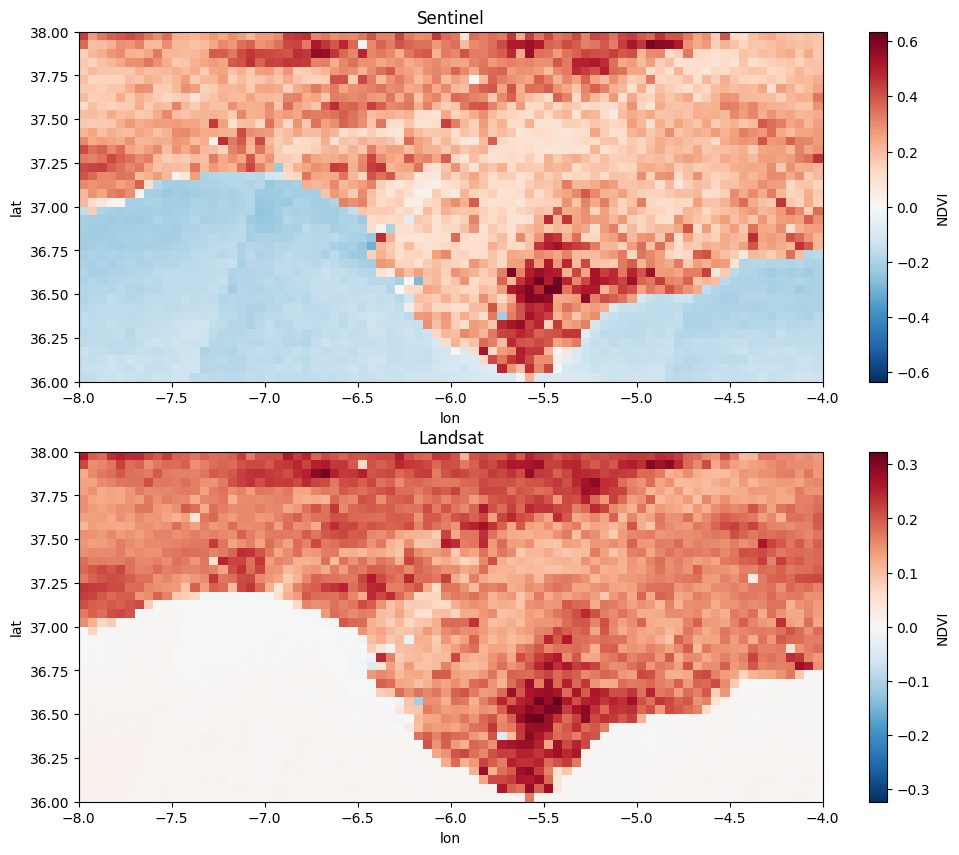

In [9]:
#1deg at midlatitude about 110km in latitude
#0.01 deg is about 110/100=1.1km

resol=0.05

Sentinel_ds=geemap.ee_to_xarray(Sentinel.median(),
                                crs='EPSG:4326',
                                scale=resol, #scale is the resolution in crs coord (here lat,lon)
                                geometry=region,
                                ee_initialize=False)

Landsat_ds=geemap.ee_to_xarray(Landsat.median(),
                               crs='EPSG:4326',
                               scale=resol, #scale is the resolution in crs coord (here lat,lon)
                               geometry=region,
                               ee_initialize=False)

feature='NDVI'
fig,ax=plt.subplots(2,1,figsize=(12,10))
Sentinel_ds[feature].plot(x='lon',ax=ax[0])
Landsat_ds[feature].plot(x='lon',ax=ax[1])

ax[0].set_title('Sentinel')
ax[1].set_title('Landsat')

fig.show()

print(len(Sentinel_ds.lon))
print(len(Sentinel_ds.lat))

In [10]:
# A digital elevation model (DEM).
# import matplotlib.cm as cm
# cmap = cm.get_cmap('viridis')
# num_colors = 4
# colors = [cmap(i/float(num_colors-1)) for i in range(num_colors)]

lat=37
lon=-6

region = ee.Geometry.Rectangle([lon-2, lat-1, lon+2, lat+1])


DEM='NASA/NASADEM_HGT/001' # elevation model without tree, building and others stuff.
#DEM='JAXA/ALOS/AW3D30/V4_1'#     ''   ''      with   ''      ''     ''  ''     ''
# for ALOS mode, call DSM instead elevation!
dem = ee.Image(DEM).select('elevation').clip(region)

# Calculate slope. Units are degrees, range is [0,90).
slope = ee.Terrain.slope(dem)


#visparam need colors in hex format,...
Visparam = {
  'min': 0,
  'max': 20,
  'palette': ['041033','E5FFCC','662A00'],
}

# Display slope  on the map.
m = geemap.Map()
m.set_center(lon,lat,8)
m.add_layer(slope, Visparam, 'Slope (deg)')
m.add_colorbar(Visparam, label="Slope (deg)")
m


#see https://www.frontiersin.org/journals/environmental-science/articles/10.3389/fenvs.2024.1419041/full
#The slope map was generated, categorizing the terrain into six distinct slope classes:
# flat plains (≤5%),
# gentle slopes (5%–10%),
# moderate slopes (11%–15%),
# moderately steep slopes (16%–20%),
# steep slopes (21%–25%),
# and very steep slopes (>25%).

Map(center=[37, -6], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(chil…

In [11]:
### Land use /land cover
# 2 choices -Copernicus  100m resol but a lot of classes
#            -ESA         10m resol but less classes


#LULC = ee.Image('COPERNICUS/Landcover/100m/Proba-V-C3/Global/2019').select('discrete_classification')

LULC=ee.ImageCollection('ESA/WorldCover/v200').first().select('Map')

# this are the classes for ESA word cover!
ee_class_table = '''
Value 	Color 	Description
10 	#006400 	Tree cover
20 	#ffbb22 	Shrubland
30 	#ffff4c 	Grassland
40 	#f096ff 	Cropland
50 	#fa0000 	Built-up
60 	#b4b4b4 	Bare / sparse vegetation
70 	#f0f0f0 	Snow and ice
80 	#0064c8 	Permanent water bodies
90 	#0096a0 	Herbaceous wetland
95 	#00cf75 	Mangroves
100 	#fae6a0 	Moss and lichen
'''

legend_dict = geemap.legend_from_ee(ee_class_table)

m = geemap.Map()
m.set_center(lon,lat,8)
m.add_layer(LULC, {}, 'Land Use Land Cover')
m.add_legend(legend_title='',
             legend_dict=legend_dict)
m



Map(center=[37, -6], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(chil…

In [12]:
#surface temperature and evaporation
#Era5 is in my function getcollection, along with the multispectralsatellite
# Era5= weather reanalysis



Era5=getCollection('era5',dates,region)

#Era5=ee.ImageCollection('ECMWF/ERA5_LAND/HOURLY').filter(ee.Filter.date(date_i,date_f)).filterBounds(region)

#note, for evaporation negative values indicate evaporation and positive values indicate condensation.
#note, 'evaporation_from_bare_soil_sum', has some issues by ECMWF

Weather=Era5.select(['temperature_2m',
                     'total_precipitation_sum',
                     'evaporation_from_vegetation_transpiration_sum',
                     'evaporation_from_bare_soil_sum',
                     'total_evaporation_sum',
                     'u_component_of_wind_10m',
                     'v_component_of_wind_10m',
                     ])

vis_params1 = {
'bands': ['evaporation_from_bare_soil_sum'],
  'min': -0.001,
  'max': 0.0000,
  'palette': [
    '000080', '0000d9', '4000ff', '8000ff', '0080ff', '00ffff',
    '00ff80', '80ff00', 'daff00', 'ffff00', 'fff500', 'ffda00',
    'ffb000', 'ffa400', 'ff4f00', 'ff2500', 'ff0a00', 'ff00ff',
  ]
};

vis_params2 = {
  'bands': ['temperature_2m'],
  'min': 280,
  'max': 300-10,
  'palette': [
    '000080', '0000d9', '4000ff', '8000ff', '0080ff', '00ffff',
    '00ff80', '80ff00', 'daff00', 'ffff00', 'fff500', 'ffda00',
    'ffb000', 'ffa400', 'ff4f00', 'ff2500', 'ff0a00', 'ff00ff',
  ]
};


#feature='total_evaporation_sum';vis_params=vis_params1
feature='temperature_2m';vis_params=vis_params2

image=Weather.median().clip(region)

m = geemap.Map()
m.centerObject(region, 8)
m.addLayer(image, vis_params, feature);
m.add_colorbar(vis_params,layer_name=feature,label=feature)
m


Map(center=[37.01238799549964, -5.999999999999887], controls=(WidgetControl(options=['position', 'transparent_…

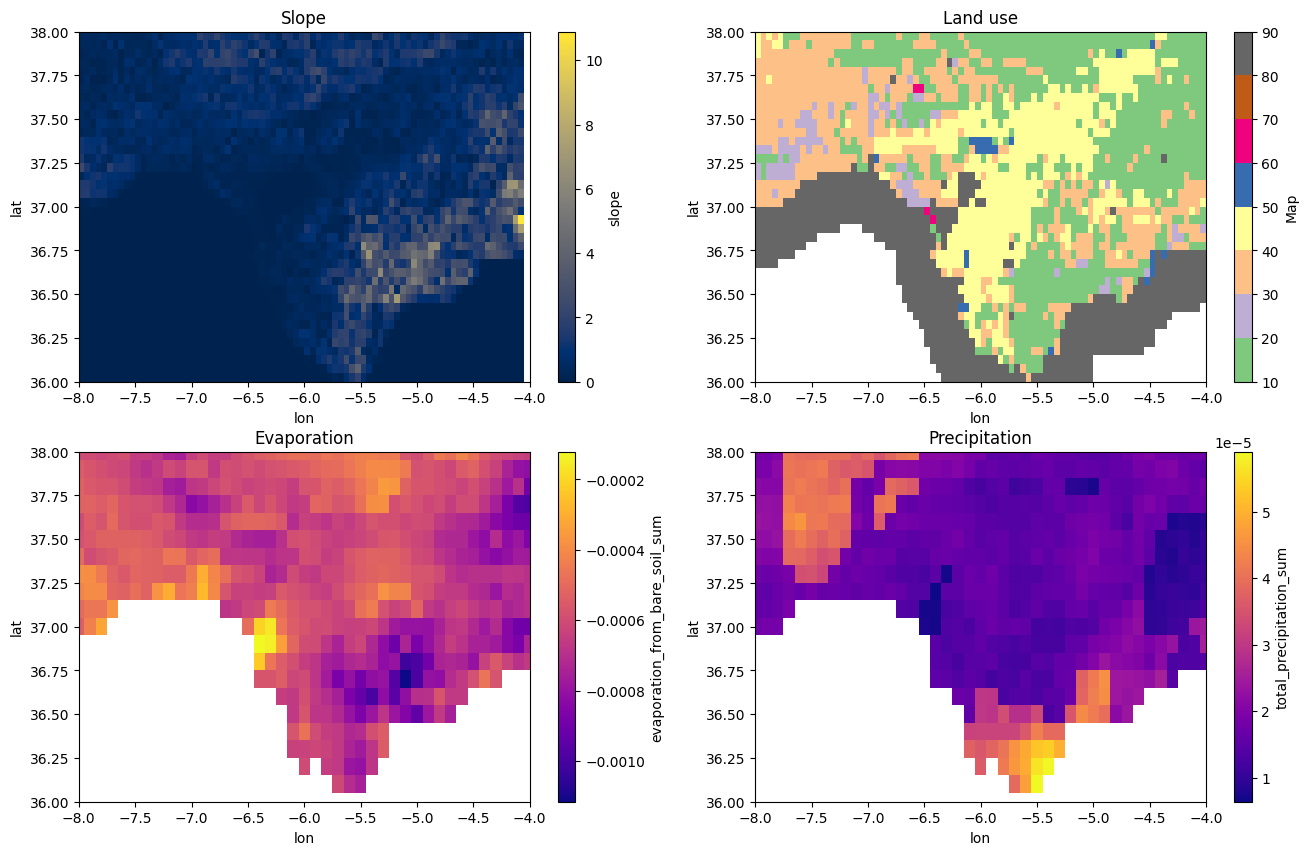

In [13]:
#convert in xarray
DEMSlope_ds=geemap.ee_to_xarray(slope,
                              crs='EPSG:4326',
                              scale=resol, #scale is the resolution in crs coord (here lat,lon)
                              geometry=region,
                              ee_initialize=False)

#convert in xarray
LULC_ds=geemap.ee_to_xarray(LULC,
                            crs='EPSG:4326',
                            scale=resol, #scale is the resolution in crs coord (here lat,lon)
                            geometry=region,
                            ee_initialize=False)


Weather_ds = geemap.ee_to_xarray(Weather.median(),
                                 crs='EPSG:4326',
                                 scale=resol, #scale is the resolution in crs coord (here lat,lon)
                                 geometry=region,
                                 ee_initialize=False,
                                 )
Weather_ds

fig,ax=plt.subplots(2,2,figsize=(16,10))
DEMSlope_ds.slope.plot(x='lon',cmap='cividis',ax=ax[0,0])
LULC_ds.Map.plot(x='lon',cmap='Accent',ax=ax[0,1])
Weather_ds.evaporation_from_bare_soil_sum.plot(x='lon',cmap='plasma',ax=ax[1,0])
Weather_ds.total_precipitation_sum.plot(x='lon',cmap='plasma',ax=ax[1,1])

ax[0,0].set_title('Slope')
ax[0,1].set_title('Land use')
ax[1,0].set_title('Evaporation')
ax[1,1].set_title('Precipitation')

fig.show()

In [14]:
################ find a way to combine those infos + satellite index
#### WATER DETECTION, Soil degradation???? or desertification???
#i.e image classification , with ResNet34???


In [15]:
#https://developers.google.com/earth-engine/guides/ic_visualization?hl=fr
# for join, see also https://developers.google.com/earth-engine/guides/joins_save_all?hl=fr
#make animated gif!



# Define GIF visualization arguments.
gifParams = {
    'region': region,
    'dimensions': 420,
    'crs': 'EPSG:3857',
    'framesPerSecond': 1, # Increased frames per second
    'format': 'gif'
}

#visual parameter
vis_params={'min': -.1, 'max': 1,
            'palette': palette1}



# Create RGB visualization images for use as animation frames.
def visualize_and_clip(img):
    # Clip the image to the region defined in gifParams
    return img.visualize(**vis_params).clip(region)


#add day
def add_date(image):
    img_date = ee.Date(image.date())
    img_date = ee.Number.parse(img_date.format('YYYYMMdd'))
    return image.set('date',img_date.toInt())


# Add day-of-year (DOY) property to each image.
def add_doy(img):
    doy = ee.Date(img.get('system:time_start')).getRelative('day', 'year')
    return img.set('doy', doy)



def create_gif(collection, feature, gifParams, interval_days=None,overlap=None):
  '''
  Creates a GIF from an Earth Engine ImageCollection.

  Args:
    collection: The Earth Engine ImageCollection.
    feature: The band/feature to visualize.
    gifParams: Dictionary of GIF visualization parameters.
    interval_days: The time interval in days between frames.
                   If None, creates a GIF for each unique date.
    overlap: time overlap between one frame and and next one, in percentage
              if 1, it means an interval is used twice, for a given frame and the next one
              If None, overlap is 0%
  Returns:
    The filename of the saved GIF.
  '''

  #Default option
  if interval_days is None:
    interval_days=16
  if overlap is None: #overlap is in percentage 0: no overlap 1=100%overlap on each side!
    overlap=0

  delta=interval_days/(2-overlap)

  # Keep only one feature to have lighter collection
  collection = collection.select(feature)


  # Create a list of dates at the specified interval
  start_date = ee.Date(date_i).advance(interval_days/2,'day')
  end_date = ee.Date(date_f).advance(-interval_days/2,'day')
  n_days = end_date.difference(start_date, 'day')
  n_steps = n_days.divide(interval_days).ceil().getInfo()
  dates_list = [start_date.advance(i * interval_days, 'day') for i in range(n_steps)]

  # Filter the collection to get images closest to the specified dates
  def get_closest_image(date):
      # Look for images within a window of half the interval before and after the date
      return collection.filterDate(date.advance(-delta, 'day'),
                                    date.advance(delta, 'day')
                                    ).median() # Use median to get a composite image if multiple are found


  comp_list = [get_closest_image(date) for date in dates_list]
  # Filter out None images from the list
  comp_list = [img for img in comp_list if img is not None]


  comp = ee.ImageCollection.fromImages(comp_list)

  print(f"Number of images in collection for GIF: {comp.size().getInfo()}") # Print number of images


  # create the RGB visualization
  rgbVis = comp.map(visualize_and_clip)

  # create gif and get the url
  url = rgbVis.getVideoThumbURL(gifParams)

  #save the gif created at the url adress
  #file2save = f"{satname}_{feature}_animation_{interval_days}days.gif"
  file2save = f"{satname}_{feature}_animation.gif"


  urllib.request.urlretrieve(url,file2save)

  return file2save

collection=Landsat
satname='Landsat'
feature='GNDVI'

# Example usage: create a GIF with frames every 30 days
file2save = create_gif(collection, feature, gifParams, interval_days=30,overlap=.25)
if file2save: # Only show image if GIF was created
    geemap.show_image(file2save)

Number of images in collection for GIF: 24


Output()

In [16]:

def add_month(image):
    img_date = ee.Date(image.date())
    img_date = ee.Number.parse(img_date.format('MM'))
    #return image.addBands(ee.Image(img_date).rename('date').toInt())
    #img.set('date',img_date)
    return image.set('month',img_date.toInt())



def create_gif_month(collection,feature,gifParams):
  ''' similar as before, but by month, if multi year, all same month are together '''

  #keep only one feature to have lighter collection
  collection = collection.select(feature)

  #define month_year
  collection = collection.map(add_month)

  # Get a list of distinct month values
  #fail!!! distinct_month_list =  ee.List.sequence(1, 12)
  distinct_month_list = collection.aggregate_array('month').distinct().sort().getInfo()

  # Map over the distinct month_year values and reduce to median
  def median_by_month(month):
      monthly_collection = collection.filterMetadata('month', 'equals', month)
      return monthly_collection.median().set('month', month)

  comp_list = [median_by_month(my) for my in distinct_month_list]
  comp = ee.ImageCollection.fromImages(comp_list)

  print(f"Number of images in collection for GIF: {comp.size().getInfo()}") # Print number of images

  # create the RGB visualization
  rgbVis = comp.map(visualize_and_clip)

  # create gif and get the url
  url = rgbVis.getVideoThumbURL(gifParams)

  #save the gif created at the url adress
  file2save = satname+'_'+feature+'_animation_month.gif'
  urllib.request.urlretrieve(url,file2save)

  return file2save

collection=Landsat
satname='Landsat'
feature='GNDVI'

file2save=create_gif_month(collection,feature,gifParams)
geemap.show_image(file2save)

Number of images in collection for GIF: 12


Output()

In [17]:
#### make some gif

collection=Landsat
satname='Landsat'
for feature in Features:
  print(feature)
  create_gif(collection,feature,gifParams,interval_days=365//12,overlap=.25)

collection=Sentinel
satname='Sentinel'
for feature in Features:
  print(feature)
  create_gif(collection,feature,gifParams,interval_days=365//12,overlap=.25)

#EEException: User memory limit exceeded with Sentinel!!!!!!
# collection=Sentinel
# for feature in Features:
#   print(feature)
#   create_gif(collection,feature,gifParams)



NDVI
Number of images in collection for GIF: 24
NDWI
Number of images in collection for GIF: 24
BSI
Number of images in collection for GIF: 24
SATVI
Number of images in collection for GIF: 24
EVI
Number of images in collection for GIF: 24
LAI
Number of images in collection for GIF: 24
GNDVI
Number of images in collection for GIF: 24
CVI
Number of images in collection for GIF: 24
NDVI
Number of images in collection for GIF: 24
NDWI
Number of images in collection for GIF: 24
BSI
Number of images in collection for GIF: 24
SATVI
Number of images in collection for GIF: 24
EVI
Number of images in collection for GIF: 24
LAI
Number of images in collection for GIF: 24
GNDVI
Number of images in collection for GIF: 24
CVI
Number of images in collection for GIF: 24


(23, 266, 420, 3)


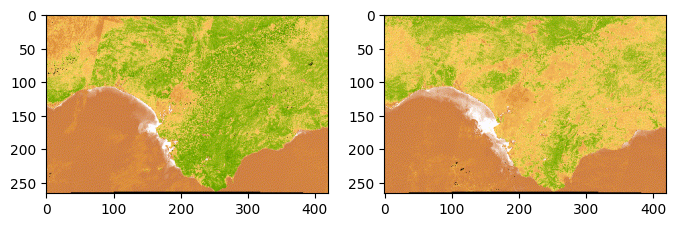

In [18]:


def load_gif(file):
  '''
  load gif and return a list of frames
  ignore index 0... not same format as other images, dont know what it is
  output is times*lat,lon,color!
  '''

  img=Image.open(file)

  frames=[]
  index=0
  for frame in ImageSequence.Iterator(img):
    if index>0:
      frames.append(np.array(frame))
    index+=1
  #print(index)
  return np.array(frames)

frames=load_gif(file=file2save)

#z=np.array(frames)
#print(z.shape)



###..................what if a combine animation????
frames_0=load_gif(file='Landsat_GNDVI_animation.gif')
#frames_1=load_gif(file='Landsat_NDWI_animation.gif')

#### note : maybe later, directly make a formula to get a new feature instead of working
## with gif
test=frames_0#+frames_1
print(test.shape)

fig,ax=plt.subplots(1,2,figsize=(8,4))
ax[0].imshow(test[0,...])
ax[1].imshow(test[-1,...])
fig.show()


#####!!!!!!!!!!!!!!!!!!!multiple index are on the same colorrange and value of range,
####ok or not???


collecting mean values at given point


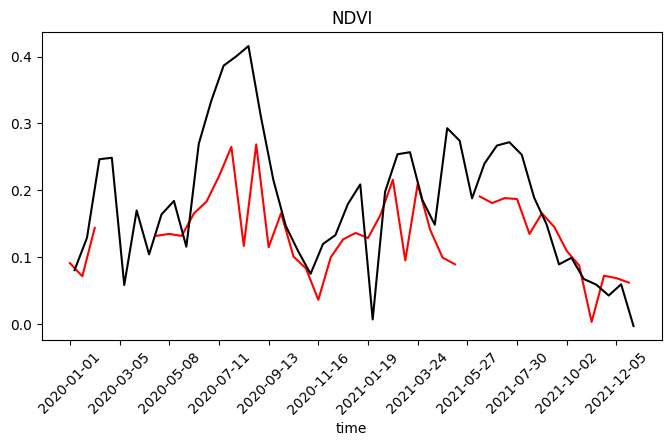

In [19]:
################################################################################################
################################################################################################
#################################### TIME SERIE ################################################



#I need long time here but a 'small' area
feature='NDVI' # index to analyze or a spectral band

poi = ee.Geometry.Point(lon,lat).buffer(1000) #point of interest with 10000m buffer circle area

date_i='2020-01-01'
date_f='2022-01-01' # I need one year at least to be able to do harmonic decomposition ('seasonal')
dates=(date_i,date_f)




#### adding some definition :
######################## Area averaging/median, std##################################

def poi_mean(img):
    '''
    Compute spatial average on a point of interest (small area) for all bands
    '''
    mean = img.reduceRegion(reducer=ee.Reducer.mean(),
                             geometry=poi,
                             bestEffort=True,
                             scale=30,
                             maxPixels=1e9
                             )
    return img.set('date', img.date().format()).set('mean',mean)
#
def poi_median(img):
    '''
    Compute spatial median on a point of interest (small area) for all bands
    '''
    median = img.reduceRegion(reducer=ee.Reducer.mean(),
                             geometry=poi,
                             bestEffort=True,
                             scale=30,
                             maxPixels=1e9
                             )
    return img.set('date', img.date().format()).set('median',median)


def poi_std(img):
    '''
    Compute spatial standard deviation on a point of interest (small area) for all bands
    '''
    mean = img.reduceRegion(reducer=ee.Reducer.stdDev(),
                             geometry=poi,
                             bestEffort=True,
                             scale=30,
                             maxPixels=1e9
                             )
    return img.set('date', img.date().format()).set('std',std)



######################## To dataframe##################################

def ImageColl_toDataFrame(ImageCollection,poi,method):
    '''
    Extract data for all bands and stack them into a dataframe
    '''
    if method=='mean':
        ImageColl_=ImageCollection.map(poi_mean)
    elif method=='std':
        ImageColl_=ImageCollection.map(poi_std)
    elif method=='median':
        ImageColl_=ImageCollection.map(poi_median)
    #
    reduced=ImageColl_.reduceColumns(ee.Reducer.toList(2), ['date',method]).values().get(0)
    data_sat=reduced.getInfo()
    #
    Df=dataSat_toDataFrame(data_sat)
    return Df


def dataSat_toDataFrame(data_sat):
    '''
    A code used in ImageColl_toDataFrame to transform satellite extracted data into a dataframe
    '''
    Q=pd.DataFrame()
    for i in range(len(data_sat)):
        time=data_sat[i][0]
        data=data_sat[i][1]
        testedkey=list(data.keys())[1]#could be other than 1, I just need a value to test
        if data[testedkey] is not None:
            q=pd.DataFrame.from_dict(data,orient='index').T
            q['time']=time
            Q=pd.concat([Q,q])
    #
    Q.index=Q.pop('time')
    return Q



#######end of definitions







Landsat=getCollection('landsat',dates,region)
Sentinel=getCollection('sentinel',dates,region)

Landsat=Landsat.map(Land_QAmask)
Sentinel=Sentinel.map(Sent_QAmask)

BAND=S_BAND
Sentinel=Sentinel.map(compute_ndvi)
Sentinel=Sentinel.map(compute_ndwi)
Sentinel=Sentinel.map(compute_bsi)
Sentinel=Sentinel.map(compute_satvi)

BAND=L8_BAND
Landsat=Landsat.map(compute_ndvi)
Landsat=Landsat.map(compute_ndwi)
Landsat=Landsat.map(compute_bsi)
Landsat=Landsat.map(compute_satvi)




#redo but on years and on point of interest, not whole large area

print('collecting mean values at given point')

method='median'
#Era5_df=ImageColl_toDataFrame(Era5,poi,method)
Land_df=ImageColl_toDataFrame(Landsat,poi,method)
Sent_df=ImageColl_toDataFrame(Sentinel,poi,method)

# convert time to timestamp
Land_df.index=pd.to_datetime(Land_df.index,utc=True)
Sent_df.index=pd.to_datetime(Sent_df.index,utc=True)


#remove date with no data
Land_df=Land_df.dropna(subset=feature)
Sent_df=Sent_df.dropna(subset=feature)

###landsat cycle is 16 days, sentinel is about 10 days,
# put them on the same time reference
Land_df=Land_df.resample('16D',axis=0).mean()
Sent_df=Sent_df.resample('16D',axis=0).mean()

#timeserie
timeformat='%Y-%m-%d'
timelabel=[x.strftime(timeformat) for x in Land_df.index]


n=4
fig,ax=plt.subplots(figsize=(8,4))
ax.plot(Land_df.index,Land_df[feature],'r',label='Landsat8')
ax.plot(Sent_df.index,Sent_df[feature],'k',label='Sentinel2')
ax.set_xlabel('time')
ax.set_xticks(Land_df.index[::n], labels=timelabel[::n])
ax.tick_params(axis='x', labelrotation=45)
ax.set_title( feature )
fig.show()




In [20]:
Land_df.index[:5]

DatetimeIndex(['2020-01-01 00:00:00+00:00', '2020-01-17 00:00:00+00:00',
               '2020-02-02 00:00:00+00:00', '2020-02-18 00:00:00+00:00',
               '2020-03-05 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='time', freq='16D')

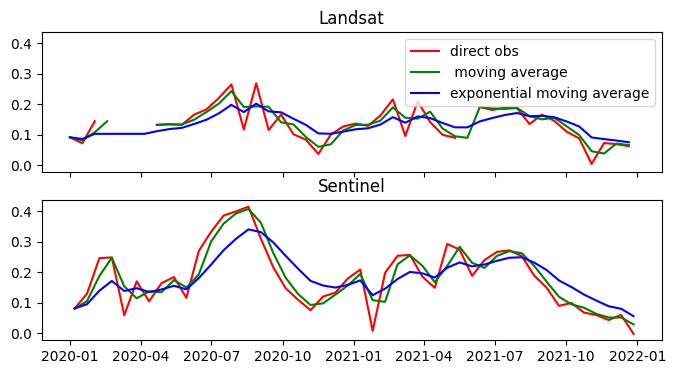

In [21]:

####rolling mean of x step? and/or exponential moving average?

#rolling mean
window = 4  # x step moving average
win_typ='hann'#'hanning' #default is boxcar
Land_rma = Land_df.rolling(window=window,win_type=win_typ,center=True,min_periods=1).mean()
Sent_rma = Sent_df.rolling(window=window,win_type=win_typ,center=True,min_periods=1).mean()

#exponential moving average
Land_ema = Land_df.ewm(halflife=window/2, adjust=False,ignore_na=True).mean()
Sent_ema = Sent_df.ewm(halflife=window/2, adjust=False,ignore_na=True).mean()

fig,ax=plt.subplots(2,figsize=(8,4),sharex=True,sharey=True)
ax[0].plot(Land_df.index,Land_df[feature],'r',label='direct obs')
ax[0].plot(Land_rma.index,Land_rma[feature],'g',label=' moving average')
ax[0].plot(Land_ema.index,Land_ema[feature],'b',label='exponential moving average')
ax[0].set_title('Landsat')
ax[0].legend()

ax[1].plot(Sent_df.index,Sent_df[feature],'r')
ax[1].plot(Sent_rma.index,Sent_rma[feature],'g')
ax[1].plot(Sent_ema.index,Sent_ema[feature],'b')
ax[1].set_title('Sentinel')

fig.show()



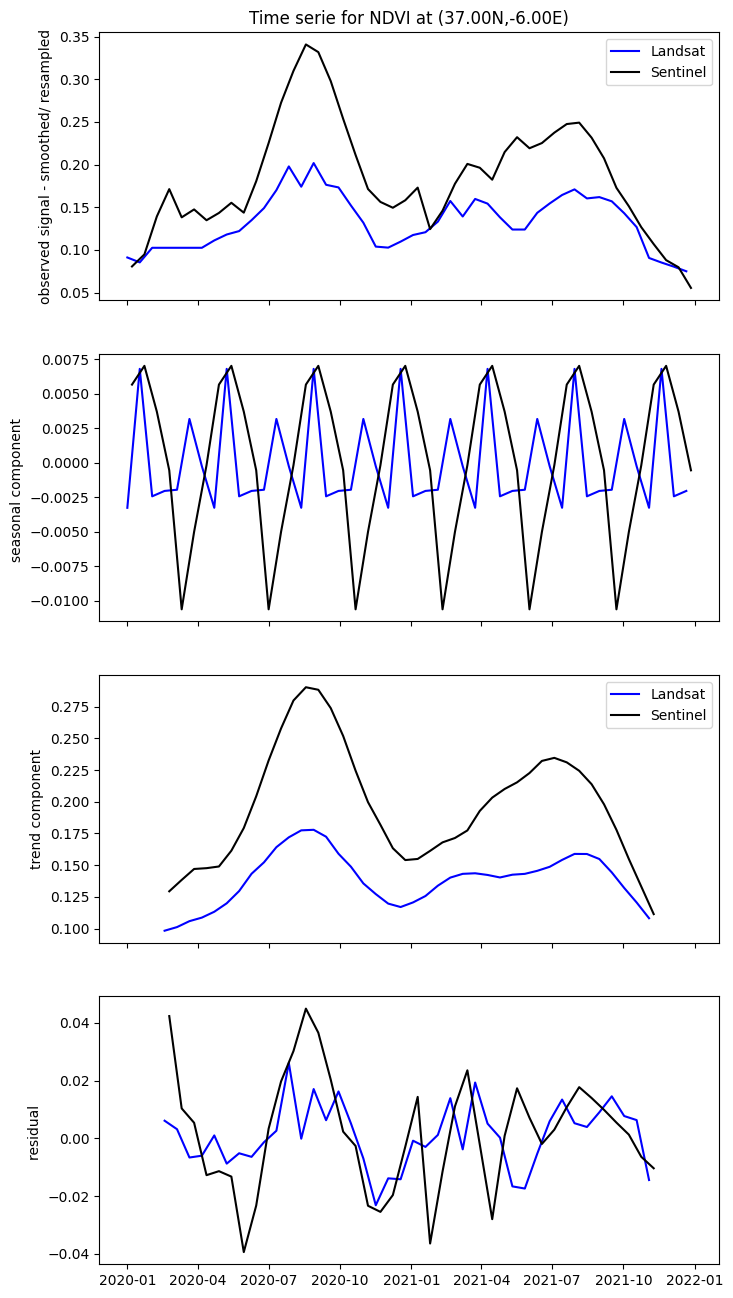

In [22]:


### time serie decomposition!
#see https://www.geeksforgeeks.org/python/time-series-decomposition-techniques/
# and https://phdinds-aim.github.io/time_series_handbook/Preface/Preface.html

#resample on 15d and interpolate
#rolling mean induce nana.... cant be interpolated
Sent_df_smooth=Sent_ema.resample('16d').mean().interpolate(method='spline',order=1)
Land_df_smooth=Land_ema.resample('16d').mean().interpolate(method='spline',order=1)

#seasonal decompose does NOT handle missing value ... but sentinel as some gaps
#interpolation required before!
Sent_decomp = seasonal_decompose(Sent_df_smooth[feature], model='additive')#,period=365//16)
Land_decomp = seasonal_decompose(Land_df_smooth[feature], model='additive')


fig,ax=plt.subplots(4,1,figsize=(8,16),sharex=True)
ax[0].plot(Land_decomp.observed,'b',label='Landsat')
ax[0].plot(Sent_decomp.observed,'k',label='Sentinel')
ax[0].set_ylabel('observed signal - smoothed/ resampled')
ax[0].legend()
ax[0].set_title('Time serie for '+ feature +' at ('+ '{:0.2f}'.format(lat) +'N,'+ '{:0.2f}'.format(lon) +'E)')
#ax[0].tick_params(labelbottom=True)

ax[1].plot(Land_decomp.seasonal,'b')
ax[1].plot(Sent_decomp.seasonal,'k')
ax[1].set_ylabel('seasonal component ')

ax[2].plot(Land_decomp.trend,'b',label='Landsat')
ax[2].plot(Sent_decomp.trend,'k',label='Sentinel')
ax[2].set_ylabel('trend component')
ax[2].legend()

ax[3].plot(Land_decomp.resid,'b')
ax[3].plot(Sent_decomp.resid,'k')
ax[3].set_ylabel('residual ')

fig.show()



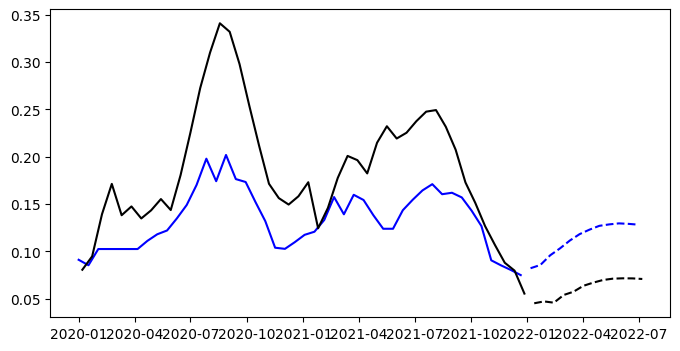

In [23]:

############################################## PREDICTION
#by using ARIMA algorithm
# ARIMA= Autoregressive Integrated Moving Average
#https://medium.com/@hazallgultekin/time-series-analysis-and-forecasting-with-arima-8be02ba2665a
#https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html
from statsmodels.tsa.arima.model import ARIMA

#ordre=(p,q,d) The parameters of the ARIMA model are defined as follows:
#    p: The lag order, representing the number of lag observations incorporated in the model.
#    d: Degree of differencing, denoting the number of times raw observations undergo differencing.
#    q: Order of moving average, indicating the size of the moving average window.
ordre=(4, 1, 2)

#define optimal order p,d,q ???

nstep=round(Sent_df_smooth.shape[0]/4)

model = ARIMA(Land_df_smooth[feature], order=ordre)
model_fit = model.fit()
# Forecast next n time step, here a timestep=15days
Land_forecast = model_fit.forecast(steps=nstep)

model = ARIMA(Sent_df_smooth[feature], order=ordre)
model_fit = model.fit()
# Forecast next n time step, here a timestep=15days
Sent_forecast = model_fit.forecast(steps=nstep)

####

fig,ax=plt.subplots(figsize=(8,4))
ax.plot(Land_df_smooth.index,Land_df_smooth[feature],'b')
ax.plot(Sent_df_smooth.index,Sent_df_smooth[feature],'k')
ax.plot(Land_forecast.index,Land_forecast,'b',linestyle='dashed')
ax.plot(Sent_forecast.index,Sent_forecast,'k',linestyle='dashed')

fig.show()
